In [1]:
using SparseArrays, LinearAlgebra, IndexedGraphs
#using Pkg
#Pkg.activ§ate("../")
using Causality
using Plots

# Generation of Epidemics

In [2]:
T, N = 20.0, 20
#G = Causality.makeBarabasi(N,k=2)
#ρ = 3/N
#G = Causality.makeGNP(N,ρ)
G = Causality.makeProximity(N,2.1/N)
#=A = [0 0 0 1 0;
     0 0 0 0 1;
     0 0 0 0 0;
     0 0 1 0 0;
     0 0 1 0 0]=#
#G = IndexedBiDiGraph(A)

{20, 78} directed sparse Int64 graph
⠠⠂⠐⠈⠁⠆⡄⠡⠱⡴
⡐⠀⠊⠀⠀⠈⠤⡠⡘⠐
⠡⠄⡀⠀⠠⠂⠌⠁⠀⠴
⠄⡉⠀⡣⠆⠁⣀⠘⠄⠁
⢑⡦⢒⠈⢀⡄⠄⠁⢀⠐

In [3]:
getpar(pseed,autoinf::GaussianRate,inf_in::GaussianRate) = 
    [fill(pseed, 1, N);
     fill(autoinf.a, 1, N); fill(autoinf.b, 1, N); fill(autoinf.c, 1, N);
     fill(inf_in.a,   1, N); fill(inf_in.b, 1, N); fill(inf_in.c, 1, N);
    ]

getpargen(pseed, autoinf::GaussianRate, inf_out::GaussianRate) = 
    [pseed autoinf.a autoinf.b autoinf.c inf_out.a inf_out.b inf_out.c]


getpargen (generic function with 1 method)

In [24]:
#Initialize generation parameters
ε = 1e-10
λ = 0.13
pseed = 1e-3
autoinf = GaussianRate(ε, T/2, 1/ε)
inf_in = GaussianRate(1.0, T/2, 1/ε)
inf_out = GaussianRate(λ, T/2, 1/ε)

θp = getpar(pseed, autoinf, inf_in);
θpgen = getpargen(pseed, autoinf, inf_out);

In [25]:
#Initialize min/max boundaies
T = Float64(T)
pseed_min = ε
pseed_max = 1-ε
rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  2T,   1/ε)

inf_min = GaussianRate(ε  ,  -T,   ε)
inf_max = GaussianRate(1/ε  ,  2T, 1. )

θmin = getpar(pseed_min , rate_min, rate_min);
θmax = getpar(pseed_max , rate_max, rate_max);

rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  T,   T)

θgenmin = getpargen(pseed_min, rate_min, rate_min);
θgenmax = getpargen(pseed_max, rate_max, rate_max);

In [26]:
const Igen = GenerativeSI{GaussianRate,GaussianRate} 
const Igauss = GaussianInferentialSI

GaussianInferentialSI

0.75


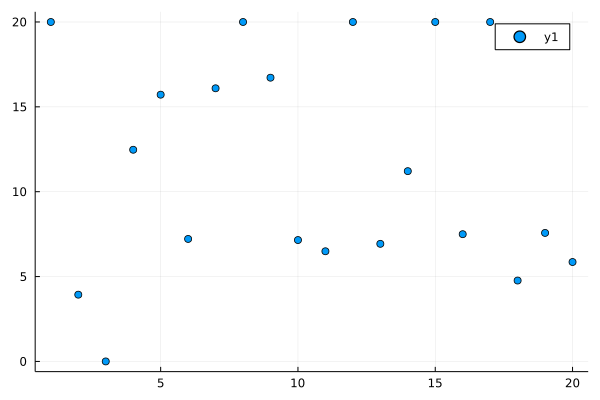

In [27]:
V = fill(MaskedRate(UnitRate(),Causality.intervalUnion(0,T)), ne(G));
Mp = StochasticModel(Igen, T, θp, G, θpgen, V);
sample! = Sampler(Mp);
xtrue = zeros(N)
ni = 0
sample!(xtrue)
#=while !(0.45 < ni < 0.55)
    sample!(xtrue)
    ni = sum(xtrue .< T)/N
end=#
println(sum(xtrue .< T)/N)
scatter(xtrue)
#scatter!(xtrue .+ 1)
#scatter!(xtrue .- 1)

In [29]:
nobs, p = 11, 1e-5 #p is mute
O = [(ti = T; (i,xtrue[i] < ti,ti,p)) for i=1:nobs]
#f_rate = 1e-5
#O=[rand()< f_rate ? (o[1],!o[2],o[3],f_rate) : (o[1],o[2],o[3],f_rate) for o in O]

11-element Vector{Tuple{Int64, Bool, Float64, Float64}}:
 (1, 0, 20.0, 1.0e-5)
 (2, 1, 20.0, 1.0e-5)
 (3, 1, 20.0, 1.0e-5)
 (4, 1, 20.0, 1.0e-5)
 (5, 1, 20.0, 1.0e-5)
 (6, 1, 20.0, 1.0e-5)
 (7, 1, 20.0, 1.0e-5)
 (8, 0, 20.0, 1.0e-5)
 (9, 1, 20.0, 1.0e-5)
 (10, 1, 20.0, 1.0e-5)
 (11, 1, 20.0, 1.0e-5)

## Causality 

In [30]:
#Softened model
T = Float64(T)
ε = 2e-3
autoinf = GaussianRate(ε, T/2, T);
θp2gen = getpargen(pseed, autoinf, inf_out);
inf_in = GaussianRate(1., T/2, 3*T );

θp2 = getpar(pseed, autoinf, inf_in);
Mp2 = StochasticModel(Igen, T, θp2, G, θp2gen, V);

In [31]:
θ = getpar(pseed, autoinf, inf_in);
autoinf = GaussianRate(1., T/2, T);
M = StochasticModel(Igauss, T, θ, G, θp2gen, V);

In [32]:
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)
F = descend!(Mp2, O; M=M, numsamples=500, numiters=50, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
         hyperdescender=SignDescender(0.));
F = descend!(Mp2, O; M=M, numsamples=500, numiters=50, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.03),
         hyperdescender=SignDescender(0.));

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
  F:  8.00832849068997


In [33]:
M.θ

7×20 Matrix{Float64}:
  0.000100149    0.00749506    0.00935145  …   0.00663511   0.0089737
  0.000536131    0.00962936    0.0223517       0.00670515   0.0186687
 24.8343         9.2951        4.89431        12.3147       9.10543
  9.03031      172.224       149.627          46.7752      46.7752
  0.0741858      1.66246       1.33488         0.987005     1.18172
  0.527334      16.9709       13.3244      …  16.9709       7.31126
  6.13414       24.9922       39.716          51.4501      47.4643

In [34]:
statscau = prior(M, numsamples=1000);

## SoftMarg

In [82]:
Osoft = [(o[1],o[2],o[3],p) for o in O]

11-element Vector{Tuple{Int64, Bool, Float64, Float64}}:
 (1, 0, 20.0, 1.0e-5)
 (2, 1, 20.0, 1.0e-5)
 (3, 1, 20.0, 1.0e-5)
 (4, 1, 20.0, 1.0e-5)
 (5, 1, 20.0, 1.0e-5)
 (6, 1, 20.0, 1.0e-5)
 (7, 1, 20.0, 1.0e-5)
 (8, 0, 20.0, 1.0e-5)
 (9, 1, 20.0, 1.0e-5)
 (10, 1, 20.0, 1.0e-5)
 (11, 1, 20.0, 1.0e-5)

In [85]:
stats, weights = softpostnoise(Mp, Osoft; numsamples=5 * 10^5);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


## Sib

In [37]:
using PyCall
@pyimport sib
function sibyl(N, T_cont, Λ, O, γ, λ ; dt=1/5, maxit = 400, tol = 1e-14)
    
    T = Int(round(T_cont / dt))
    contacts = [(i-1,j-1,t, λ * dt) for t in 1:T for (j,i,v) in zip(findnz(Λ.A)...)];
    obs = [[(i,-1,t) for t=1:T for i=0:N-1];
           [(i-1,s,Int(round(t/dt))) for (i,s,t,p) in O]]
    sort!(obs, lt=((i1,s1,t1),(i2,s2,t2))->(t1<t2))
    prob_sus = 0.5
    prob_seed=γ
    pseed = prob_seed / (2 - prob_seed)
    psus = prob_sus * (1 - pseed)
    params = sib.Params(prob_r=sib.Exponential(mu=0), pseed=pseed, psus=psus,pautoinf=0,fp_rate=0,fn_rate=0)
    f = sib.FactorGraph(contacts=contacts, observations=obs, params=params)
    sib.iterate(f, maxit=maxit,tol=tol)
    sib.iterate(f, maxit=maxit, damping=0.5, tol=tol)
    sib.iterate(f, maxit=maxit, damping=0.9, tol=tol)
    p_sib=[collect(n.bt) for n in f.nodes]
    m_sib = zeros(N, T)
    for i=1:N
        m_sib[i,1] = p_sib[i][1] 
        for t=2:T
            m_sib[i,t] = m_sib[i,t-1] + p_sib[i][t]
        end
    end 
    return m_sib
end


sibyl (generic function with 1 method)

In [38]:
a=time()
dt = 1/4
p_sib = sibyl(N, T, G, O, pseed, λ; dt=dt, maxit = 20, tol = 1e-7);
b=time()
println(b-a)

sib.iterate(damp=0.0): 19/20 3.963e-02/1e-07      
sib.iterate(damp=0.5): 19/20 2.785e-02/1e-07      
21.169769048690796.9): 19/20 2.493e-02/1e-07      


# Heuristic

In [39]:
using IntervalUnionArithmetic
T = Float64(T)
struct HeuristicSI <: SI end
θp2gen = getpargen(pseed, autoinf, inf_out);
maskauto = fill(intervalUnion(0., T),N)
maskinf = fill(intervalUnion(0., T),N)
θfrench = getpar(pseed, autoinf, inf_in);
Causality.individual(M::StochasticModel{HeuristicSI}, i::Int, θi = @view(M.θ[:,i]), θg = M.θgen ) = 
@views IndividualSI(θi[1], 
    MaskedRate(GaussianRate(θi[2:4]...),maskauto[i]), 
    MaskedRate(UnitRate(),maskinf[i]), 
    GaussianRate(θg[5:7]...),)
inf_start_time = T * ones(N)
for o in O
    if o[2] == 1
        inf_start_time[o[1]] = min(inf_start_time[o[1]], o[3] - 5)
        maskauto[o[1]] = maskauto[o[1]] ∩ intervalUnion(o[3]-5, T)       
        θfrench[2,o[1]] = 10^10
        θfrench[3,o[1]] = o[3] - 5
        θfrench[4,o[1]] = 100 * T
    elseif o[2] == 0
        maskinf[o[1]] = maskinf[o[1]] ∩ intervalUnion(o[3], T)
        maskauto[o[1]] = maskauto[o[1]] ∩ intervalUnion(o[3], T)
        θfrench[1,o[1]] = 1e-10
    end
end
for i=1:N
    if inf_start_time[i] != T 
        maskauto[i] = maskauto[i] ∩ intervalUnion(inf_start_time[i], T)
    end
end
Mfrench = StochasticModel(HeuristicSI, T, θfrench, G, θp2gen);
statsfre = prior(Mfrench,numsamples=10000); 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [40]:
function MF_heu(N, T_cont, Λ, O, γ, λ ; dt=1/5, maxit = 400)
    T = Int(round(T_cont / dt))
    p_MF = zeros(N,T) #prob to be S
    p_MF[:,1] .= 1 - γ 
    obs_I = [o[1] for o in O if o[2] == 1]
    obs_S = [o[1] for o in O if o[2] == 0]
    for st = 1:maxit
        for t = 2:T
            for i = 1:N
                p_MF[i,t] = p_MF[i,t-1]
                for j in collect(Causality.outedges(Λ,1))
                    p_MF[i,t] *= 1 - λ*(1 - p_MF[j.dst,t-1])
                end
                if i in obs_I                    
                    o = O[i]
                    p_MF[i, Int(round((o[3]-5)/dt)) : end] .= 0
                end
                if i in obs_S
                    o = O[i]
                    p_MF[i, 1 : Int(round(o[3]/dt))] .= 1
                end
            end
        end
    end
    return 1 .- p_MF
end

MF_heu (generic function with 1 method)

In [41]:
p_MF = MF_heu(N, T, G, [], 1/N, λ ; dt=dt, maxit = 100)

20×80 Matrix{Float64}:
 0.05  0.0744602  0.109779  0.15952  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.05  0.0744602  0.109779  0.15952     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.05  0.0744602  0.109779  0.15952     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.05  0.0744602  0.109779  0.15952     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.05  0.0744602  0.109779  0.15952     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.05  0.0744602  0.109779  0.15952  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.05  0.0744602  0.109779  0.15952     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.05  0.0744602  0.109779  0.15952     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.05  0.0744602  0.109779  0.15952     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.05  0.0744602  0.109779  0.15952     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.05  0.0744602  0.109779  0.15952  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.05  0.0744602  0.109779  0.15952     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.05  0.0744602  0.109779  0.15952     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.05  0.074460

## Metropolis Monte Carlo

In [ ]:
K =  Causality.RectifiedGaussMove(4.0)
#stats_mh = Causality.metropolis_sampling_parallel(Mp, O, K; numsamples = 10^3,numsteps=10^3,nfirst = 10^3)
stats_mh = Causality.metropolis_sampling_sequential(Mp, O, K; numsamples = 5 * 10^5,numsteps=10^2,nfirst = 10^4);
stats_mh1 = Causality.metropolis_sampling_sequential(Mp, O, K; numsamples = 10^3,numsteps=10,nfirst = 10^3);

Progress:  46%|██████████████████▋                      |  ETA: 0:41:04
  acc_ratio:  0.35


## Marginals and ROC curve

In [ ]:
function marginal(i, t, stats)
    numsamp = size(stats,1)
    sum(stats[:,i] .< t)/numsamp
end

function reweighted_marginal(i, t, stats, weights)
    numsamp = size(stats,1)
    @assert numsamp == size(weights,1)
    weights ./= maximum(weights)
    sum(weights .* (stats[:,i] .< t))/sum(weights)
end

function tpr(xtrue, rank) 
    cumsum(xtrue[rank]) ./( cumsum(xtrue[rank])[end])
end

function fpr(xtrue, rank) 
    N = size(rank,1)
    return (range(1,N,length=N) .- cumsum(xtrue[rank])) ./ (range(1,N,length=N) .- cumsum(xtrue[rank]) )[end]
end

function ROC(xtrue, p)
    N = size(xtrue,1)
    rank = sortperm(p, rev=true)
    
    return fpr(xtrue, rank) , tpr(xtrue, rank)
end

function AUROC(ROC)
    N = size(ROC[1],1) 
    AU = 0
    for t = 1:N-1
        AU += ROC[2][t] * (ROC[1][t+1] - ROC[1][t])
    end
    return AU
end

In [ ]:
#Marginals
bins = 2 * Int(T)
using Plots
p_cau = zeros(N,bins)
p_french = zeros(N,bins)
p_mh = zeros(N,bins)
p_mh1 = zeros(N,bins)
p_soft = zeros(N,bins)
for i = 1:N
    for t = 1:bins
       p_cau[i,t] = marginal(i, t*T/bins, statscau)
       p_french[i,t] = marginal(i, t*T/bins, statsfre)
       p_mh[i,t] = marginal(i, t*T/bins, stats_mh)
       p_mh1[i,t] = marginal(i, t*T/bins, stats_mh1) 
       p_soft[i,t] = reweighted_marginal(i, t*T/bins, stats, weights)
    end
end

In [ ]:
O

In [121]:

i = 11
#p1 = plot(LinRange(1,Int(T),bins-1),diff(p_cau[i,:]), label = "cau")
p1 = plot(LinRange(1,Int(T),bins-1),diff(p_soft[i,:]), label = "soft")
p1 = plot!(LinRange(1,Int(T),bins-1),diff(p_mh[i,:]), label = "MH")
#p1 = plot!(LinRange(1,Int(T),bins-1),diff(p_mh1[i,:]), label = "MH_iter=10")

i = 19
#p2 = plot(LinRange(1,Int(T),bins-1),diff(p_cau[i,:]), label = "cau")
p2 = plot(LinRange(1,Int(T),bins-1),diff(p_soft[i,:]), label = "soft")
p2 = plot!(LinRange(1,Int(T),bins-1),diff(p_mh[i,:]), label = "MH")
#p2 = plot!(LinRange(1,Int(T),bins-1),diff(p_mh1[i,:]), label = "MH_iter=10")

i = 17
#p3 = plot(LinRange(1,Int(T),bins-1),diff(p_cau[i,:]), label = "cau")
p3 = plot(LinRange(1,Int(T),bins-1),diff(p_soft[i,:]), label = "soft")
p3 = plot!(LinRange(1,Int(T),bins-1),diff(p_mh[i,:]), label = "MH")
#p3 = plot!(LinRange(1,Int(T),bins-1),diff(p_mh1[i,:]), label = "MH_iter=10")

i = 9
#p4 = plot(LinRange(1,Int(T),bins-1),diff(p_cau[i,:]), label = "cau")
p4 = plot(LinRange(1,Int(T),bins-1),diff(p_soft[i,:]), label = "soft")
p4 = plot!(LinRange(1,Int(T),bins-1),diff(p_mh[i,:]), label = "MH")
#p4 = plot!(LinRange(1,Int(T),bins-1),diff(p_mh1[i,:]), label = "MH_iter=10")

plot(p1,p2,p3,p4,size=(1000,500))

savefig("comparison.pdf")

In [49]:
#AUROC curves

T = Int(T)
AU_curve=zeros(T)
AU_curveLoc=zeros(T)
AU_sib=zeros(T)
AU_MF=zeros(T)
AU_french = zeros(T)
AU_soft = zeros(T)
AU_MH = zeros(T)
for t = 1:T
    cau_risk=zeros(N)
    cau_riskLoc=zeros(N)
    sib_risk = zeros(N)
    MF_risk = zeros(N)
    french_risk = zeros(N)
    MH_risk = zeros(N)
    soft_risk = zeros(N)
    for i=1:N
       cau_risk[i] = marginal(i,t,statscau)
        #cau_riskLoc[i] = marginal(i,t,statscauLoc)
       french_risk[i] = marginal(i,t,statsfre)
       MH_risk[i] = marginal(i,t,stats_mh)
       sib_risk[i] = p_sib[i,Int(round(t/dt))]
        MF_risk[i] = p_MF[i,Int(round(t/dt))]
       soft_risk[i] = reweighted_marginal(i, t*T/bins, stats, weights)
    end
    xt = xtrue .< t
    AU_soft[t] = AUROC(ROC(xt, soft_risk))
    AU_curve[t] = AUROC(ROC(xt, cau_risk))
    #AU_curveLoc[t] = AUROC(ROC(xt, cau_riskLoc))
    AU_french[t] = AUROC(ROC(xt, french_risk))
    AU_MH[t] = AUROC(ROC(xt, MH_risk))
    AU_sib[t] = AUROC(ROC(xt, sib_risk))
    AU_MF[t] = AUROC(ROC(xt, MF_risk))
end

plot(LinRange(1,T,T),AU_curve, label="AUCau", title="Causality VS Sib AUROC in function of time")
scatter!(LinRange(1,T,T),AU_soft, label="AUSoft",legend=:bottomleft)
#plot!(LinRange(1,T,T),AU_french, label="AUFrench")
scatter!(LinRange(1,T,T),AU_MH, label="AUMH")
#plot!(LinRange(1,T,T),AU_curveLoc, label="Loc")
#scatter!(LinRange(1,T,T), AU_sib, label="AUsib")
#scatter!(LinRange(1,T,T), AU_MF, label="AUMF")
xlabel!("t")
ylabel!("AUROC")
#savefig("confronti.pdf")
#ylims!(0.5,1.01)

LoadError: UndefVarError: stats_mh not defined